In [1]:
import random
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [14]:
orders = pd.read_csv('../temp/orders_unmatched.csv')
print('length: ' + str(len(orders)))
orders.insert(loc=5, column='tracking_code', value="")
orders.head(2)

length: 1000


,order_id,customer_id,order_date,order_type,order_status,tracking_code,shipping_amount
0,14553-9UPH02,14553,2019-01-06,Online,Shipped,,5.83
1,12854-8AYI90,12854,2015-03-07,Online,Shipped,,15.07


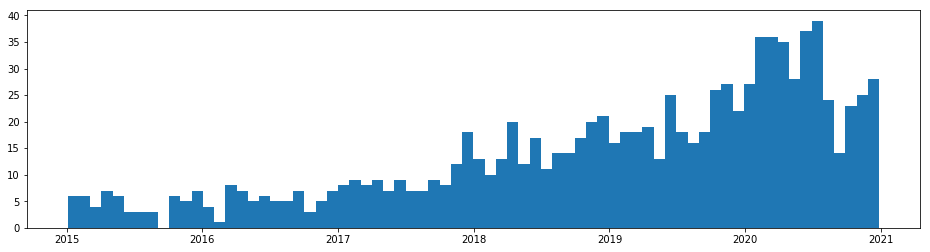

In [71]:
df = pd.DataFrame(pd.to_datetime(orders['order_date']))
plt.figure(figsize=(16,4))
plt.hist(df['order_date'], 72)
plt.show()

In [70]:
order_lines = pd.read_csv('../temp/order_lines.csv')
print('order lines: ' + str(len(order_lines)))
order_lines.head(2)

length: 1000


,product_id,price,quantity
0,150,20.71,1
1,140,27.14,1


Load campaigns

In [72]:
campaigns = pd.read_csv('../source/campaigns.csv')
campaigns['start_dt'] = pd.to_datetime(campaigns['start_date'])
campaigns['end_dt'] = pd.to_datetime(campaigns['end_date'])
campaigns.head()

,campaign_id,start_date,end_date,campaign,country,start_dt,end_dt
0,10001,2015-01-02,2015-01-06,2015 Transcof 7AR009,US,2015-01-02,2015-01-06
1,10002,2015-01-16,2015-01-26,2015 Domainer 9YO534,US,2015-01-16,2015-01-26
2,10003,2015-02-11,2015-02-23,2015 Ronstring 4QT243,US,2015-02-11,2015-02-23
3,10004,2015-03-05,2015-03-17,2015 Fintone 2PG648,US,2015-03-05,2015-03-17
4,10005,2015-03-26,2015-04-03,2015 Solarbreeze 9XQ101,US,2015-03-26,2015-04-03


In [73]:
channels = pd.read_csv('../source/campaign_channels.csv')
channels.head()

,campaign_id,channel_id,category,channel,budget,spend,tracking_code,campaign_channel_id
0,10001,605,In-Store,Signage,3200,4000,4NQSPX,10001IN4NQSPX
1,10001,904,Social,Forum,3900,3588,6FWEOU,10001SO6FWEOU
2,10002,723,Web,Microsites,2000,2400,7WHGTM,10002WE7WHGTM
3,10003,303,Direct,Postal Mail,4800,4896,9JUSKL,10003DI9JUSKL
4,10003,905,Social,Influencer outreach,2100,1995,3XNYND,10003SO3XNYND


In [74]:
def find_tracking_code(order_date):
    # campaigns that are effective around our order_date
    potential_campaigns = campaigns[(order_date >= campaigns['start_dt']) \
                                & (order_date <= campaigns['end_dt'])]
    pcl = len(potential_campaigns) # potential_campaigns length (could be zero)
    
    # select one of found campaigns at random, or none
    # This part is a little tricky
    #   if pcl is 0, then rn will be 0 and we return blank
    #   if pcl is 2, and rn is 2 then we return blank
    #     otherwise rn is an index into potential_campaigns
    rn = random.randint(0,pcl) # 
    if rn < pcl :
        cid = potential_campaigns.iloc[rn]['campaign_id'] # Chosen Campaign ID
    else:
        return ''
    # Find a channel
    pch = channels[channels['campaign_id'] == cid] # potential channels
    pchl = len(pch) # pot channels len
    sch = pd.Series() # selected channel
    if pchl == 0:
        return ''
    # retrive the selected channel
    return pch.iloc[random.randint(0,pchl-1)]['tracking_code']


In [81]:
# Loop through each order, construct a combined master/detail row, one or more order-lines per order

new_orders = pd.DataFrame(columns=['order_id', 'customer_id', 'order_date', 'order_type', 'order_status', 'tracking_code', \
                                   'shipping_amount', 'order_line_id', 'product_id', 'price', 'quantity'])
n_order_lines = len(order_lines)
new_orders_idx = 0
order_lines_idx = 0
order_line = 1

for i, row in orders.iterrows():

    # Get a tracking code if one is selected
    tc = find_tracking_code(row['order_date'])
    order_line = 1
    
    while True:
        new_orders.loc[new_orders_idx] = row
        new_orders.loc[new_orders_idx, 'order_line_id'] = row['order_id']+'-'+str(order_line)
        new_orders.loc[new_orders_idx, 'tracking_code'] = tc
        new_orders.loc[new_orders_idx, "product_id"] = order_lines.loc[order_lines_idx, "product_id"]
        
        # add a bit of inflation to the prices
        price = float(order_lines.loc[order_lines_idx, "price"])
        year = pd.to_datetime(row['order_date']).year
        new_price = round(price * (1.05**(year-2014)),2)
        
        new_orders.loc[new_orders_idx, "price"] = new_price
        new_orders.loc[new_orders_idx, "quantity"] = order_lines.loc[order_lines_idx, "quantity"]
        
        new_orders_idx = new_orders_idx + 1
        order_line = order_line + 1
        # Don't exceed the index into the order_lines dataframe
        order_lines_idx = order_lines_idx + 1 if order_lines_idx + 1 < n_order_lines else 0
        
        # Decide whether to add another order line (geometric progression)
        if random.randint(0,1) == 0:
            break;

In [82]:
new_orders.head(n=10)

,order_id,customer_id,order_date,order_type,order_status,tracking_code,shipping_amount,order_line_id,product_id,price,quantity
0,14553-9UPH02,14553,2019-01-06,Online,Shipped,3QCYDA,5.83,14553-9UPH02-1,150.0,26.43,1.0
1,12854-8AYI90,12854,2015-03-07,Online,Shipped,,15.07,12854-8AYI90-1,140.0,28.50,1.0
2,12468-1MOT78,12468,2020-05-04,Online,Shipped,,10.32,12468-1MOT78-1,160.0,19.51,4.0
3,12468-1MOT78,12468,2020-05-04,Online,Shipped,,10.32,12468-1MOT78-2,310.0,38.03,1.0
4,12468-1MOT78,12468,2020-05-04,Online,Shipped,,10.32,12468-1MOT78-3,150.0,26.48,1.0
5,12937-2PRS51,12937,2020-05-06,Retail,Completed,,6.49,12937-2PRS51-1,150.0,27.50,1.0
6,13575-5KKN76,13575,2018-12-22,Online,Shipped,7HXYYX,17.26,13575-5KKN76-1,160.0,20.03,1.0
7,12895-7GQF05,12895,2019-05-04,Retail,Completed,0ZHUBW,13.69,12895-7GQF05-1,120.0,51.00,1.0
8,10480-4VCX54,10480,2019-11-26,Online,Shipped,3HUFVC,9.75,10480-4VCX54-1,140.0,34.93,3.0
9,10480-4VCX54,10480,2019-11-26,Online,Shipped,3HUFVC,9.75,10480-4VCX54-2,150.0,26.92,1.0


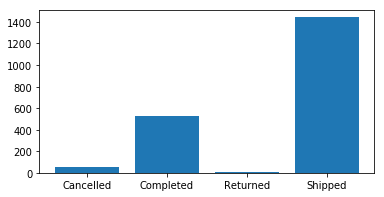

In [53]:
plt.clf()
# this group by is not working how it should
plt.bar(np.sort(new_orders['order_status'].unique()),new_orders.groupby('order_status')['order_id'].count())
plt.show()

In [167]:
newfilename='../source/orders_1_' + str(int(datetime.datetime.now().timestamp())) + '.csv'
new_orders.to_csv(newfilename, encoding='utf-8', index=False)